Device: cuda


C:\Users\gabri\anaconda3\envs\workenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\gabri\anaconda3\envs\workenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/15], Train Loss: 1.5744, Val Loss: 0.7441
New best model found at epoch 1, saving the model...
Epoch [2/15], Train Loss: 0.7699, Val Loss: 0.5578
New best model found at epoch 2, saving the model...
Epoch [3/15], Train Loss: 0.5910, Val Loss: 0.5497
New best model found at epoch 3, saving the model...
Epoch [4/15], Train Loss: 0.4728, Val Loss: 0.4782
New best model found at epoch 4, saving the model...
Epoch [5/15], Train Loss: 0.4366, Val Loss: 0.5222
Epoch [6/15], Train Loss: 0.4083, Val Loss: 0.4603
New best model found at epoch 6, saving the model...
Epoch [7/15], Train Loss: 0.4442, Val Loss: 0.5746
Epoch [8/15], Train Loss: 0.3475, Val Loss: 0.5081
Epoch [9/15], Train Loss: 0.2957, Val Loss: 0.4439
New best model found at epoch 9, saving the model...
Epoch [10/15], Train Loss: 0.2623, Val Loss: 0.4126
New best model found at epoch 10, saving the model...
Epoch [11/15], Train Loss: 0.2480, Val Loss: 0.4464
Epoch [12/15], Train Loss: 0.2501, Val Loss: 0.4342
Epoch [13/15]

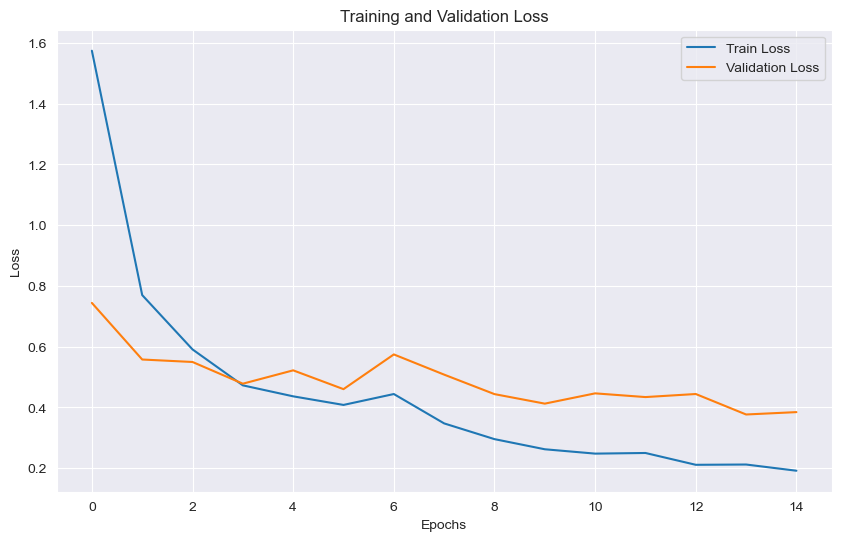

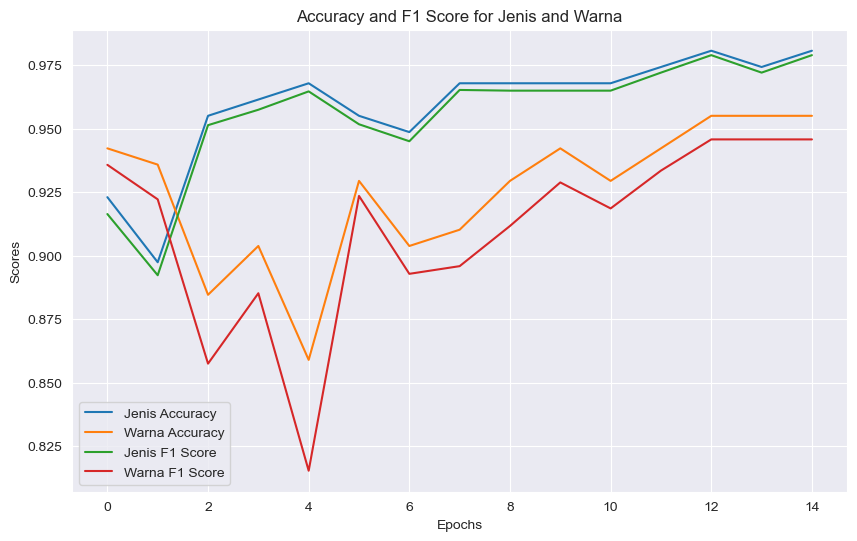

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss, jaccard_score
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import WeightedRandomSampler

# Define device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

# Paths
train_img_folder = '../Penyisihan_Hology_DataMining/train'  # Update with the path to your train folder
csv_file = '../Penyisihan_Hology_DataMining/train.csv'  # Update with the path to your train.csv

# Image size
IMG_SIZE = (224, 224)

# Augmentasi dataset untuk training
data_transforms_train = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),  # Flip horizontal secara acak
    transforms.RandomVerticalFlip(p=0.5),    # Flip vertikal secara acak
    transforms.RandomRotation(degrees=15),   # Rotasi acak hingga 15 derajat
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Ubah kontras, saturasi, dll.
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),  # Crop acak dan resize
    transforms.RandomGrayscale(p=0.1),      # Ubah ke grayscale dengan probabilitas 10%
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalisasi
])

# Untuk validasi, augmentasi tidak diperlukan, hanya preprocessing dasar
data_transforms_val = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalisasi
])

# Load train.csv
train_df = pd.read_csv(csv_file)

# Custom dataset class
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_id = self.dataframe.iloc[idx]['id']
        jenis_label = self.dataframe.iloc[idx]['jenis']
        warna_label = self.dataframe.iloc[idx]['warna']

        img_path = None
        try:
            img_extensions = ['.jpg', '.JPG', '.png']  # Handle multiple extensions
            for ext in img_extensions:
                potential_path = os.path.join(self.img_dir, f"{img_id}{ext}")
                if os.path.exists(potential_path):
                    img_path = potential_path
                    break
            if img_path:
                image = Image.open(img_path).convert('RGB')  # Convert image to RGB to avoid mode errors
            else:
                print(f"Image {img_id} not found.")
                image = Image.new('RGB', IMG_SIZE)  # Create a blank image if there's an error

        except Exception as e:
            print(f"Error loading image {img_id} from {img_path}: {str(e)}")
            image = Image.new('RGB', IMG_SIZE)  # Create a blank image if there's an error

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        return image, jenis_label, warna_label

# Split the data into train and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Create dataset and dataloaders
train_dataset = CustomImageDataset(train_df, train_img_folder, transform=data_transforms_train)
val_dataset = CustomImageDataset(val_df, train_img_folder, transform=data_transforms_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load EfficientNetB0 pretrained on ImageNet
model = models.efficientnet_b0(pretrained=True)

# Modify the classifier to output 2 classes for 'jenis' and 5 classes for 'warna'
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(num_features, 512),  # Optional layer to reduce dimensions
    nn.ReLU(),
    nn.Linear(512, 7)  # 2 for jenis + 5 for warna
)

# Move model to GPU if available
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# **Implementasi Scheduler Learning Rate**
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Evaluate function to calculate metrics after each epoch
def evaluate_model(model, val_loader):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels_jenis = []
    all_labels_warna = []

    with torch.no_grad():
        for images, jenis_labels, warna_labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            jenis_outputs = outputs[:, :2].cpu().numpy()
            warna_outputs = outputs[:, 2:].cpu().numpy()

            all_preds.append(np.concatenate([jenis_outputs, warna_outputs], axis=1))
            all_labels_jenis.append(jenis_labels.cpu().numpy())
            all_labels_warna.append(warna_labels.cpu().numpy())

    all_preds = np.vstack(all_preds)
    all_labels_jenis = np.hstack(all_labels_jenis)
    all_labels_warna = np.hstack(all_labels_warna)
    
    # Binarize predictions and labels
    preds_jenis = np.argmax(all_preds[:, :2], axis=1)
    preds_warna = np.argmax(all_preds[:, 2:], axis=1)

    # Calculate metrics
    accuracy_jenis = accuracy_score(all_labels_jenis, preds_jenis)
    accuracy_warna = accuracy_score(all_labels_warna, preds_warna)

    precision_jenis = precision_score(all_labels_jenis, preds_jenis, average='macro')
    precision_warna = precision_score(all_labels_warna, preds_warna, average='macro')

    recall_jenis = recall_score(all_labels_jenis, preds_jenis, average='macro')
    recall_warna = recall_score(all_labels_warna, preds_warna, average='macro')

    f1_jenis = f1_score(all_labels_jenis, preds_jenis, average='macro')
    f1_warna = f1_score(all_labels_warna, preds_warna, average='macro')

    hamming = hamming_loss(np.hstack([all_labels_jenis, all_labels_warna]), np.hstack([preds_jenis, preds_warna]))

    jaccard_jenis = jaccard_score(all_labels_jenis, preds_jenis, average='macro')
    jaccard_warna = jaccard_score(all_labels_warna, preds_warna, average='macro')

    return {
        'accuracy_jenis': accuracy_jenis,
        'accuracy_warna': accuracy_warna,
        'precision_jenis': precision_jenis,
        'precision_warna': precision_warna,
        'recall_jenis': recall_jenis,
        'recall_warna': recall_warna,
        'f1_jenis': f1_jenis,
        'f1_warna': f1_warna,
        'hamming_loss': hamming,
        'jaccard_jenis': jaccard_jenis,
        'jaccard_warna': jaccard_warna
    }

# Train the model with metric evaluation and store loss
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20):
    train_losses = []
    val_losses = []
    metrics_list = []
    best_val_loss = float('inf')  # Mulai dengan nilai terbaik yang sangat besar
    best_model_wts = None  # Untuk menyimpan model dengan performa terbaik

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0

        for images, jenis_labels, warna_labels in train_loader:
            images, jenis_labels, warna_labels = images.to(device), jenis_labels.to(device), warna_labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            jenis_outputs = outputs[:, :2]  # First 2 outputs for 'jenis'
            warna_outputs = outputs[:, 2:]  # Next 5 outputs for 'warna'

            jenis_loss = criterion(jenis_outputs, jenis_labels)
            warna_loss = criterion(warna_outputs, warna_labels)

            # Combine losses
            loss = jenis_loss + warna_loss

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation loop
        val_loss = 0.0
        with torch.no_grad():
            for images, jenis_labels, warna_labels in val_loader:
                images, jenis_labels, warna_labels = images.to(device), jenis_labels.to(device), warna_labels.to(device)

                outputs = model(images)
                jenis_outputs = outputs[:, :2]
                warna_outputs = outputs[:, 2:]

                jenis_loss = criterion(jenis_outputs, jenis_labels)
                warna_loss = criterion(warna_outputs, warna_labels)
                val_loss += (jenis_loss + warna_loss).item()

        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)

        # Evaluate metrics after each epoch
        metrics = evaluate_model(model, val_loader)
        metrics_list.append(metrics)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # Check if the validation loss is the best we've seen so far, and if so, save the model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = model.state_dict().copy()  # Save the best model weights
            print(f"New best model found at epoch {epoch+1}, saving the model...")

        # **Update Scheduler**
        scheduler.step()

    # Save the best model after the training loop
    if best_model_wts is not None:
        torch.save(best_model_wts, './base4_result/best_efficientnet_multilabel_model.pth')
        print("Best model saved.")
    else:
        print("No improvement during training.")

    return train_losses, val_losses, metrics_list

# Visualize loss and evaluation metrics
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

def plot_metrics(metrics_list):
    accuracy_jenis = [m['accuracy_jenis'] for m in metrics_list]
    accuracy_warna = [m['accuracy_warna'] for m in metrics_list]
    f1_jenis = [m['f1_jenis'] for m in metrics_list]
    f1_warna = [m['f1_warna'] for m in metrics_list]

    plt.figure(figsize=(10, 6))
    plt.plot(accuracy_jenis, label='Jenis Accuracy')
    plt.plot(accuracy_warna, label='Warna Accuracy')
    plt.plot(f1_jenis, label='Jenis F1 Score')
    plt.plot(f1_warna, label='Warna F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('Scores')
    plt.title('Accuracy and F1 Score for Jenis and Warna')
    plt.legend()
    plt.show()

# **Run training dengan Scheduler**
train_losses, val_losses, metrics_list = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=15
)

# Plot results
plot_losses(train_losses, val_losses)
plot_metrics(metrics_list)


In [2]:
import torch
from torchvision import transforms
import pandas as pd
from PIL import Image
import os
import numpy as np

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the saved model
model = models.efficientnet_b0(pretrained=False)  # Initialize model architecture
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Linear(512, 7)  # 2 for 'jenis' and 5 for 'warna'
)
model.load_state_dict(torch.load('./base4_result/best_efficientnet_multilabel_model.pth'))  # Load weights
model = model.to(device)
model.eval()  # Set to evaluation mode

# Folder for test images
test_img_folder = '../Penyisihan_Hology_DataMining/test'

C:\Users\gabri\anaconda3\envs\workenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\gabri\anaconda3\envs\workenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [3]:
# Image transformations
IMG_SIZE = (224, 224)
data_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalization for pre-trained models
])

# Load test images from folder (assuming all images are in the same format, e.g., .jpg)
def load_test_images_from_folder(folder, start_id=778):
    images = []
    img_ids = []
    
    # Sort filenames to ensure consistent ordering
    filenames = sorted([
        filename for filename in os.listdir(folder)
        if filename.lower().endswith(('.jpg', '.jpeg', '.png'))  # Handle multiple formats
    ])
    
    current_id = start_id
    for filename in filenames:
        img_path = os.path.join(folder, filename)
        try:
            image = Image.open(img_path).convert('RGB')  # Open image and convert to RGB
            image = data_transforms(image)  # Apply transformations
            images.append(image)
            img_ids.append(current_id)
            current_id += 1
        except Exception as e:
            print(f"Error loading image {filename}: {str(e)}")
            continue  # Skip the image if there's an error
    
    if not images:
        raise ValueError("No images were loaded. Please check the test image folder.")
    
    return torch.stack(images), img_ids  # Return tensor and corresponding image IDs

# Load test images and generate sequential IDs starting from 778
test_images, test_img_ids = load_test_images_from_folder(test_img_folder, start_id=778)
test_images = test_images.to(device)


In [4]:
with torch.no_grad():
    outputs = model(test_images)

# Split the predictions for 'jenis' and 'warna'
jenis_predictions = torch.argmax(outputs[:, :2], dim=1).cpu().numpy()  # First 2 outputs for 'jenis'
warna_predictions = torch.argmax(outputs[:, 2:], dim=1).cpu().numpy()  # Next 5 outputs for 'warna'


In [5]:
# Create a DataFrame to store the results
result_df = pd.DataFrame({
    'id': test_img_ids,  # Use the extracted IDs from filenames
    'jenis': jenis_predictions,
    'warna': warna_predictions
})

# Save the results to CSV
result_df.to_csv('./base4_result/test_predictions.csv', index=False)

print("Predictions saved to 'test_predictions.csv'.")


Predictions saved to 'test_predictions.csv'.
